# Change sign with ordering of operator

With fermionic system, a state is defined with a conventional ordering of fermionic operators. For example:

$$ | 1001 \rangle = c_1^\dagger c_4^\dagger | 0 \rangle = - c_4^\dagger c_1^\dagger | 0 \rangle $$
$$ | 1110 \rangle = c_1^\dagger c_2^\dagger c_3^\dagger | 0 \rangle $$

The Hamiltonian should reflect this because `create` and `destroy` do not have the good anticommutation relations.

### ??? (https://github.com/qutip/qutip/issues/863)

I think this works:

c0 = qutip.tensor([qutip.destroy(2), identity(2)])
c1 = qutip.tensor([sigmaz(), qutip.destroy(2)])

More generally c_k should be tensored with k copies of sigmaz() to the left and n-k copies of identity to the right. When operators are applied on vacuum in descending order, by definition there is no fermion to the left of the operator so the sigmaz() is irrelevant. When operators are applied in the opposite order, a negative is picked up. Thus every pair of commutation relations is satisfied. I think that is sufficient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

from scipy.optimize import minimize
from scipy.signal import argrelmin

In [2]:
T = 0.03
beta = 1/T

# The discretized values of omega
omega = np.linspace(-10, 10, 100000, dtype = complex)

# The Matsubara frequencies
max_freq = 3
n_freq = int(((max_freq * beta / np.pi) - 1) / 2) + 1
matsu_freq = (2 * np.array(range(-n_freq, n_freq), dtype = complex) + 1) * np.pi / beta

# The small delta
delta = 1e-3

In [119]:
# Plots complex array by showing real and imaginary parts
def plot_complex(a, is_matsu = True):
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    if is_matsu:
        ax[0].plot(np.real(matsu_freq), np.real(a))
        ax[1].plot(np.real(matsu_freq), np.imag(a))
    else:
        ax[0].plot(np.real(omega), np.real(a))
        ax[1].plot(np.real(omega), np.imag(a))
    ax[0].set_title("Real Part")
    ax[1].set_title("Imaginary Part")

We retrieve the parameters $\{V_k, \epsilon_k\}_k$ of the Anderson impurity model from the hybridization function:

$$\Delta(\omega) = \sum_k \frac{V_k^2}{\omega - \epsilon_k + i\delta}$$

We place ourselves at half-filling so that $\mu = \frac U2$, and the AIM hamiltonian reads:

$$H = U n_\uparrow n_\downarrow - \frac U 2 (n_\uparrow + n_\downarrow) + \sum_{k,\sigma} \epsilon_k a_{k,\sigma}^\dagger a_{k,\sigma} + \sum_{k,\sigma} V_k (a_{k,\sigma}^\dagger c_\sigma + c_\sigma^\dagger a_{k,\sigma})$$

where $a_{k,\sigma}^\dagger$ denotes the creation operator of an electron in the bath, $c_\sigma^\dagger$ denotes the creation operator of the impurity electron and $n_\sigma = c_\sigma^\dagger c_\sigma$.

### Retrieval of the hamiltonian parameters

$\Delta(\omega)$ is represented as an array of complex numbers corresponding to different values of $\omega$. We recover the hamiltonian parameters $\{V_k, \epsilon_k\}_k$ by optimizing a function:

$$f : \{V_k, \epsilon_k\}_k \to \Delta(\omega) $$

against the real $\Delta(\omega)$.

To obtain an initial guess, we use the fact that the local minima of $\Im (\Delta(\omega))$ are the $\epsilon_k$ and that close to $\epsilon_k$, its contribution will dominate so that:

$$V_k^2 \approx - \delta \Im (\Delta(\epsilon_k))$$

In [4]:
def hybridizationFunction(V, e):
    n = len(V)
    s = omega * 0
    for k in range(n):
        s += V[k]**2 / (omega - e[k] + 1.j * delta)
    return s

def hamParameters(hyb_func, n_k, verbose = False):
    
    # The format of the argument of optimize_me is V_i, e_i
    def optimize_me(args):
        n = len(args)
        V = args[:n//2]
        e = args[n//2:]
        return np.linalg.norm(hyb_func - hybridizationFunction(V, e))
    
    # Obtain initial guess
    
    # The energies are the minimums of the imaginary part
    e_ini = np.real(omega[argrelmin(np.imag(hyb_func))])
    
    # The V_k are approximately sqrt(delta ** 2 * hyb_func(e_k)
    V_ini = np.sqrt(-delta * np.imag(hyb_func)[argrelmin(np.imag(hyb_func))[0]])
    
    args_ini = np.zeros(2 * n_k)
    args_ini[:n_k] = V_ini
    args_ini[n_k:] = e_ini
    
    if verbose:
        print(optimize_me(args_ini))
        print("\nV_ini: ")
        print(V_ini)
        print("\ne_ini: ")
        print(e_ini)
    
    # minimize optimize_me based on the initial guess
    res = minimize(optimize_me, args_ini, method = 'BFGS')
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [145]:
# Check that it works properly

n_k = 4
V = [9.3, 12.1, 2.1, 5.5]
e = [-3,-7,9,4]

hyb_func = hybridizationFunction(V, e)
hamParameters(hyb_func, n_k)

(array([12.09999559,  9.30000403,  5.4999936 ,  2.09997706]),
 array([-7.00000001, -3.        ,  4.        ,  9.00000002]),
 2.581014680362732)

In [78]:
# Same thing but with Matsubara frequencies

def matsuHybridizationFunction(V, e):
    n = len(V)
    s = matsu_freq * 0
    for k in range(n):
        s += V[k]**2 / (1.j * matsu_freq - e[k])
    return s

def matsuHamParameters(matsu_hyb_func, n_k):
    
    # The format of the argument of matsu_optimize_me is V_i, e_i
    def matsu_optimize_me(args):
        n = len(args)
        V = args[:n//2]
        e = args[n//2:]
        return np.linalg.norm(matsu_hyb_func - matsuHybridizationFunction(V, e)) ** 2
    
    args_ini = np.zeros(2 * n_k)
    
    # minimize matsu_optimize_me
    res = minimize(matsu_optimize_me, args_ini, method = 'Powell', tol = 1e-10)
    V = res.x[:n_k]
    e = res.x[n_k:]
    return V, e, res.fun

In [79]:
matsuHamParameters(matsu_hyb_func, 2)

(array([1.48113327e-11, 1.48113327e-11]),
 array([2.61803395, 2.61803395]),
 903.419287217747)

In [ ]:
matsu_hyb_func = matsuHybridizationFunction(V, e)

In [6]:
# Check that it works properly

n_k = 3
V = [3.6, 2.3, 8.1]
e = [-2.1, 1.1, -3.1]

matsu_hyb_func = matsuHybridizationFunction(V, e)
matsuHamParameters(matsu_hyb_func, n_k)

(array([  8.77028143, -21.05539242,   2.25084468]),
 array([-2.82991072e+00,  5.78229730e+13,  1.06589743e+00]),
 0.19138362508525045)

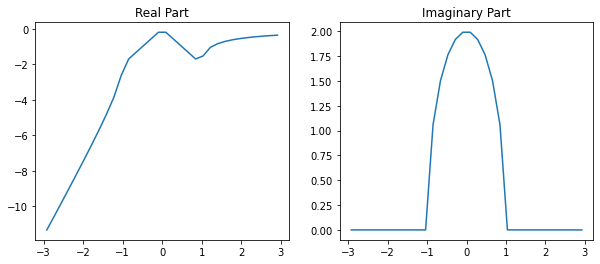

In [47]:
plot_complex(matsu_hyb_func)

### Constructing the hamiltonian

Using the hamiltonian parameters $\{V_k, \epsilon_k\}_k$, we can now construct the hamiltonian. We use the following convention indexing the sites with $i$:
- If $i$ is even, the site has spin up
- If $i$ is odd, the site has spin down
- $i//2 = 0$ indicates the impurity site
- $i//2 = k > 0$ indicates site k - 1

For example 100100 indicates that the spin up impurity site and the spin down first bath level are filled.

In [8]:
def AIM(V, e, U):
    
    # Number of sites in the bath
    nk = len(V)
    
    # Total number of sites
    n = 2 * (nk + 1)
    
    # Impurity on-site interaction
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    prod[1] = num(2)
    H1 = U * tensor(prod)
    
    # Impurity chemical potential
    prod = [qeye(2) for x in range(n)]
    prod[0] = num(2)
    H2 = - (U/2) * tensor(prod)
    prod = [qeye(2) for x in range(n)]
    prod[1] = num(2)
    H2 += - (U/2) * tensor(prod)
    
    # Bath energy levels
    H3 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            prod = [qeye(2) for x in range(n)]
            prod[2*(k + 1) + spin] = num(2)
            H3 += e[k] * tensor(prod)
    
    # Bath-impurity interaction
    H4 = H1 * 0
    for k in range(nk):
        for spin in range(2):
            
            prod = [qeye(2) for x in range(n)]
            prod[spin] = destroy(2)
            prod[2*(k + 1) + spin] = create(2)
            H4 += V[k] * tensor(prod)
            
            prod = [qeye(2) for x in range(n)]
            prod[spin] = create(2)
            prod[2*(k + 1) + spin] = destroy(2)
            H4 += V[k] * tensor(prod)
            
    return H1 + H2 + H3 + H4

In [124]:
create(2)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [9]:
H = AIM([2,4], [3, 7], 1)
H

Quantum object: dims = [[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape = (64, 64), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  7.  0. ...  0.  0.  0.]
 [ 0.  0.  7. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 13.  0.  0.]
 [ 0.  0.  0. ...  0. 13.  0.]
 [ 0.  0.  0. ...  0.  0. 20.]]

In [10]:
H[int('001001', 2), int('101000', 2)]

0j

### Impurity Green's function

$$ G(i \omega_k) = \frac{1}{Z} \sum_{n,n'} \frac{|\langle n' | c_\uparrow^\dagger | n \rangle|^2}{i \omega_k + E_n - E_{n'}} \left( e^{-\beta E_n} + e^{-\beta E_{n'}} \right) $$

In [11]:
# Returns the spin up impurity green's function given the hamiltonian

def impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0
            
            prob = (ei.H @ ej)[0,0]
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (omega + eigvals[j] - eigvals[i] + 1.j * delta)
    
    return G / Z

Every energies should be degenerated twice

Real frequency GF should have symmetric peak

In [12]:
# Returns the spin up impurity green's function with Matsubara frequencies given the hamiltonian

def matsu_impurity_green(H, T):
    
    beta = 1/T
    
    # Get the eigendecomposition
    eigvals, eigvecs = np.linalg.eigh(H._data.todense())
    n = len(eigvals)
    
    # The partition function
    Z = np.sum(np.exp(-beta * eigvals))
    
    # Green's function
    G = 0
    for i in range(n):
        for j in range(n):
            
            ei = eigvecs[:,i].copy()
            ej = eigvecs[:,j].copy()
            
            # Computing c^dagger|j>
            ej[n//2:] = ej[:n//2]
            ej[:n//2] = 0
            
            prob = (ei.H @ ej)[0,0]
            
            G += prob * (np.exp(-beta * eigvals[i]) + np.exp(-beta * eigvals[j])) / (1.j * matsu_freq + eigvals[j] - eigvals[i])
    
    return G / Z

In [13]:
# Returns the spin up impurity green's function given the hybridization function

def loopstep(hyb_func, n_k, U, T):
    V, e, val = hamParameters(hyb_func, n_k)
    H = AIM(V, e, U)
    G = impurity_green(H, T)
    return G

In [122]:
# Returns the spin up impurity green's function given the hybridization function

def matsu_loopstep(matsu_hyb_func, n_k, U, T, verbose = False):
    print("Retrieving hamiltonian parameters")
    V, e, val = matsuHamParameters(matsu_hyb_func, n_k)
    print("Optimization MSE: {:.4}".format(val))
    print(V)
    print(e)
    H = AIM(V, e, U)
    print("Computing green's function\n")
    G = matsu_impurity_green(H, T)
    return G

# DMFT loop

We work on the Bethe lattice for a simplified loop: $\Delta(\omega) = t^2 G_\text{imp}$

We start with $$\Delta_0(\omega) = \frac{\omega - \sqrt{\omega^2 - 4t^2}}{2t^2}$$
or $$\Delta_0(i\omega_n) = \frac{i\omega_n - \sqrt{-\omega_n^2 - 4t^2}}{2t^2} = \frac{i\omega_n - i\sqrt{\omega_n^2 + 4t^2}}{2t^2}$$

Step 1
Retrieving hamiltonian parameters
Optimization MSE: 0.5569
[0.61199111 0.61199115]
[-0.18304568  0.18304571]
Computing green's function

Step 2
Retrieving hamiltonian parameters
Optimization MSE: 1.47
[ 0.71584691 30.01376412]
[9.41834385e-03 3.70527101e+03]
Computing green's function

Step 3
Retrieving hamiltonian parameters
Optimization MSE: 15.76
[1.03656901e-10 1.03656901e-10]
[2.61803395 2.61803395]
Computing green's function

Step 4
Retrieving hamiltonian parameters
Optimization MSE: 39.47
[1.94248949e-11 1.94248949e-11]
[2.61803395 2.61803395]
Computing green's function

Step 5
Retrieving hamiltonian parameters
Optimization MSE: 184.4
[1.14682321e-11 1.14682321e-11]
[2.61803395 2.61803395]
Computing green's function

Step 6
Retrieving hamiltonian parameters
Optimization MSE: 184.4
[-2.86060352e-10 -2.86060352e-10]
[2.61803395 2.61803395]
Computing green's function

Step 7
Retrieving hamiltonian parameters
Optimization MSE: 3.894e-21
[ 0.70710678 -0.70710678]
[-0.05  0.05]

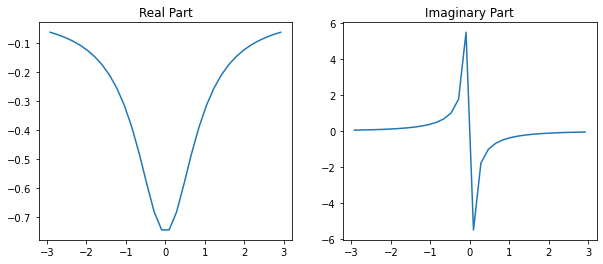

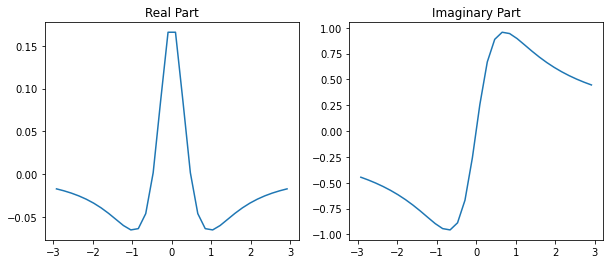

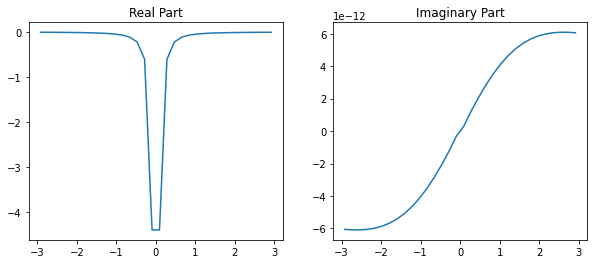

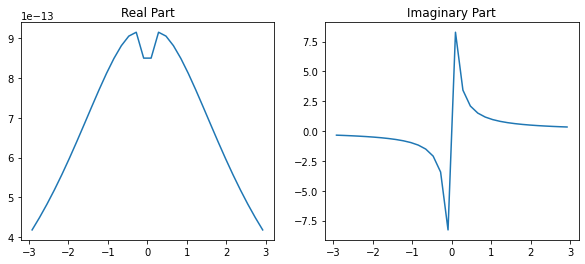

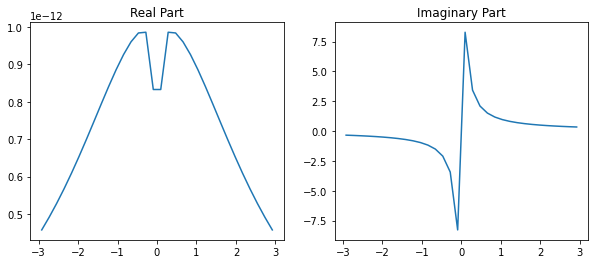

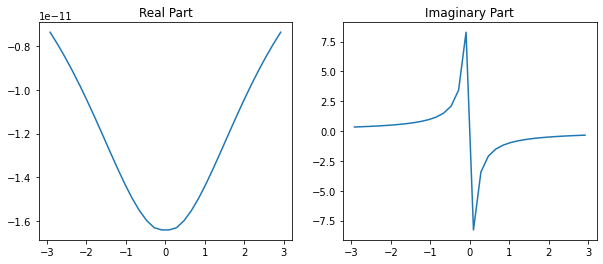

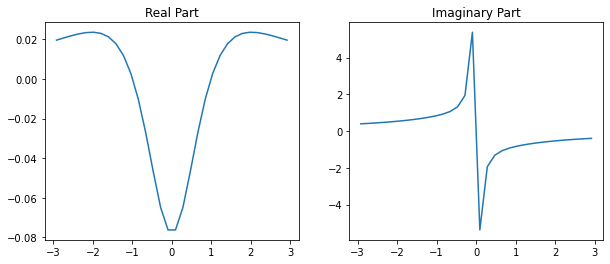

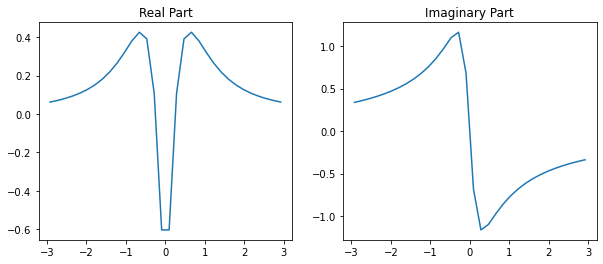

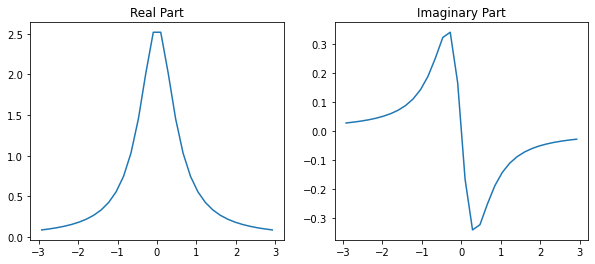

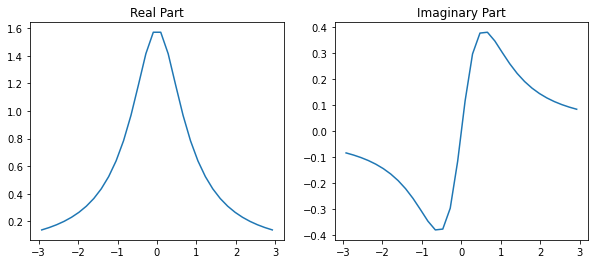

In [123]:
# In Matsubara frequency

# T was defined above
n_k = 2
U = 0.1

#matsu_hyb_func = np.sign(np.real(matsu_freq)) * (matsu_freq - (matsu_freq ** 2 - 1) ** 0.5) * 2
matsu_hyb_func = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 1) ** 0.5) * 2

for k in range(10):
    print("Step {}".format(k + 1))
    matsu_hyb_func = matsu_loopstep(matsu_hyb_func, n_k, U, T)
    plot_complex(matsu_hyb_func, is_matsu = True)

print("Done")

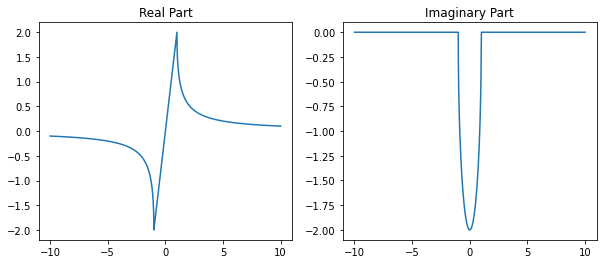

In [117]:
hyb_func = (omega - np.sign(np.real(omega)) * (omega ** 2 - 1) ** 0.5) * 2
plot_complex(hyb_func, is_matsu = False)

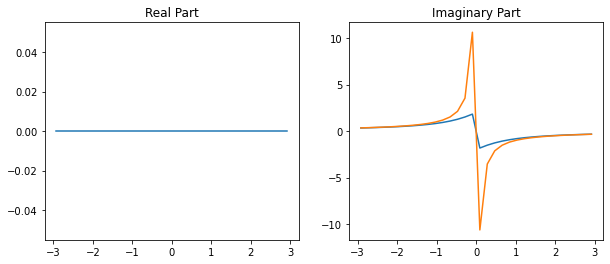

In [113]:
#matsu_hyb_func = - np.sign(np.real(matsu_freq)) * (matsu_freq - (matsu_freq ** 2 - 1) ** 0.5) * 2
matsu_hyb_func = (1.j * matsu_freq - np.sign(np.real(matsu_freq)) * 1.j * (matsu_freq ** 2 + 1) ** 0.5) * 2
plot_complex(matsu_hyb_func, is_matsu = True)

In [105]:
matsuHamParameters(matsu_hyb_func, 2)

(array([1.48113327e-11, 1.48113327e-11]),
 array([2.61803395, 2.61803395]),
 903.419287217747)

### Random notes

$$ G(i\omega_n) = G^*(-i\omega_n) $$

Matsubara Green's function should have symmetric real part and antisymmetric imaginary part. Retarded Green's function should be the opposite: antisymmetric real part and symmetric imaginary part.

The extrapolation at 0 of the imaginary part of $G(i\omega_n)$ should be $A(0)$ (The value at 0 of the corresponding spectral function).

The imaginary part of $G(i\omega_n)$ should decay as $1/\omega_n$.